## Book Recommendation System 

The project contains the recommendation system with simplest recommendations and content based on the filtering methods.

In this project my aim was to analyzed data about books and I have explored two kind of recommendations - the simplest recommendations and content-based filtering. The final result will show that user can input one book's name then the system can provide the other suggested books that he can to read.

The objective of a book recommendation system is to predict buyer’s interest and recommend books to them respectively. That system can take into regard many parameters like book content and quality by filtering user reviews. 

**Dataset:**

The dataset comes from Google Books Dataset data and can be find in Kaggle.

Columns Description:

- title: the title of the book.
- author: name of the authors of the books (might include more than one author.
- rating: the average rating of each book out of 5.
- voters: the number of voters to the book.
- price: price of the book on the google books store
- currency: the currency of the price in the google books store.
- description: brief introductory description of the book.
- publisher: the name of the publisher.
- pageCount: number of pages of the books.
- generes: the categories associated with the book (by Google store)
- ISBN: the unique identifier for each book.
- language: the language of the book
- publishedDate: when the book was published.


### Import libraries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv(r'C:\Python Scripts\Datasets\google books\google_books_1299.csv')
df.head()

,Unnamed: 0,title,author,rating,voters,price,currency,description,publisher,page_count,generes,ISBN,language,published_date
0,0,Attack on Titan: Volume 13,Hajime Isayama,4.6,428,43.28,SAR,NO SAFE PLACE LEFT At great cost to the Garris...,Kodansha Comics,192,none,9781612626864,English,"Jul 31, 2014"
1,1,Antiques Roadkill: A Trash 'n' Treasures Mystery,Barbara Allan,3.3,23,26.15,SAR,Determined to make a new start in her quaint h...,Kensington Publishing Corp.,288,"Fiction , Mystery &amp, Detective , Cozy , Gen...",9780758272799,English,"Jul 1, 2007"
2,2,The Art of Super Mario Odyssey,Nintendo,3.9,9,133.85,SAR,Take a globetrotting journey all over the worl...,Dark Horse Comics,368,"Games &amp, Activities , Video &amp, Electronic",9781506713816,English,"Nov 5, 2019"
3,3,Getting Away Is Deadly: An Ellie Avery Mystery,Sara Rosett,4.0,10,26.15,SAR,"With swollen feet and swelling belly, pregnant...",Kensington Publishing Corp.,320,none,9781617734076,English,"Mar 1, 2009"
4,4,"The Painted Man (The Demon Cycle, Book 1)",Peter V. Brett,4.5,577,28.54,SAR,The stunning debut fantasy novel from author P...,HarperCollins UK,544,"Fiction , Fantasy , Dark Fantasy",9780007287758,English,"Jan 8, 2009"


First observations:

In [4]:
df.shape

(1299, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1299 non-null   int64  
 1   title           1299 non-null   object 
 2   author          1299 non-null   object 
 3   rating          1224 non-null   float64
 4   voters          1224 non-null   object 
 5   price           1299 non-null   float64
 6   currency        1299 non-null   object 
 7   description     1296 non-null   object 
 8   publisher       1299 non-null   object 
 9   page_count      1299 non-null   int64  
 10  generes         1299 non-null   object 
 11  ISBN            1299 non-null   object 
 12  language        1299 non-null   object 
 13  published_date  1299 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 142.2+ KB


Checking for missing values:

In [6]:
df.isnull().sum()

Unnamed: 0         0
title              0
author             0
rating            75
voters            75
price              0
currency           0
description        3
publisher          0
page_count         0
generes            0
ISBN               0
language           0
published_date     0
dtype: int64

In [7]:
df.columns

Index(['Unnamed: 0', 'title', 'author', 'rating', 'voters', 'price',
       'currency', 'description', 'publisher', 'page_count', 'generes', 'ISBN',
       'language', 'published_date'],
      dtype='object')

Checking for unique values:

In [8]:
df.language.unique()

array(['English'], dtype=object)

In [9]:
df.publisher.value_counts()

HarperCollins UK             112
Hachette UK                  112
Penguin                       75
Simon and Schuster            71
DC                            52
                            ... 
Hay House, Inc                 4
Kodansha America LLC           4
Disha Publications             4
One Acre Press                 3
Archie Comic Publications      3
Name: publisher, Length: 82, dtype: int64

In [10]:
df.generes.value_counts()

none                                            527
Fiction , Thrillers , Suspense                   35
Fiction , Fantasy , Epic                         33
Comics &amp, Graphic Novels , Superheroes        30
Fiction , Mystery &amp, Detective , General      21
                                               ... 
Social Science , Gender Studies                   1
True Crime , General                              1
Philosophy , History &amp, Surveys , General      1
Technology &amp, Engineering , General            1
Fiction , Fantasy , Contemporary                  1
Name: generes, Length: 242, dtype: int64

There are total 1299 rows with 14 columns and there are missing values in columns rating, voters and description. 

### Data preparation

Firstly I prepare the data to further analysis. I drop the unnecessary column and I change type of 'publication_date' column from object to detatime. Then I extract publication year into separate column. For the column 'description' I replace missing values with an empty string and for column 'voters' I fill NaN with 0. There are many duplicates in the data so I remove them as well. 

In [11]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [12]:
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

In [13]:
df['Year'] = pd.to_datetime(df['published_date']).dt.to_period('Y')

Removing duplicates from the data:

In [14]:
df2 = df.drop_duplicates(keep=False)

In [15]:
df2 = df2.drop_duplicates(['title'], keep='first')

Missing values:

In [16]:
#replace NaN with an empty string
df2['description'] = df2['description'].fillna('')

In [17]:
#removing commas
df2['voters'] = df2['voters'].replace(',','', regex=True)

In [18]:
#filling with 0
df2['voters'] = df2['voters'].fillna(0)

In [19]:
#changing type for int
df2['voters'] = df2['voters'].astype(int) 

In [20]:
df2.dtypes

title                     object
author                    object
rating                   float64
voters                     int32
price                    float64
currency                  object
description               object
publisher                 object
page_count                 int64
generes                   object
ISBN                      object
language                  object
published_date    datetime64[ns]
Year               period[A-DEC]
dtype: object

In [21]:
df2.shape

(225, 14)

From above analysis one can see that in data were many duplicates. After removed them only 225 rows were left.

### Exploratory Data Analysis

Some information about the data:

In [22]:
df2.describe()

,rating,voters,price,page_count
count,212.000000,225.000000,225.000000,225.000000
mean,4.415094,914.720000,49.679911,372.613333
std,0.364618,3748.326083,64.858412,402.514981
min,2.500000,0.000000,0.000000,15.000000
25%,4.200000,11.000000,26.510000,176.000000
50%,4.500000,84.000000,39.340000,304.000000
75%,4.700000,408.000000,62.820000,404.000000
max,5.000000,38526.000000,886.080000,4544.000000


In [23]:
avg_rating = round(df2['rating'].mean(),1)
avg_vot = round(df2['voters'].mean(),)

print(f"The average ratings of the book are {avg_rating}.\nThe average number of voters are {avg_vot}. ")

The average ratings of the book are 4.4.
The average number of voters are 915. 


From above short analysis one can see that the highest average rating a book can get is 5.0 and the lowest average rating a book can get is 2.5. The average number of rating are 4.4 and number of voters are 915.

**The top 10 authors with most number of books published:**

In [24]:
authors = df2['author'].value_counts().head(10)
authors

Brian Tracy            6
Robert Jordan          5
Blake Pierce           5
Morgan Rice            5
Agatha Christie        4
Disha Experts          4
Geoff Johns            4
Barbara Allan          4
Andrzej Sapkowski      3
George R. R. Martin    3
Name: author, dtype: int64

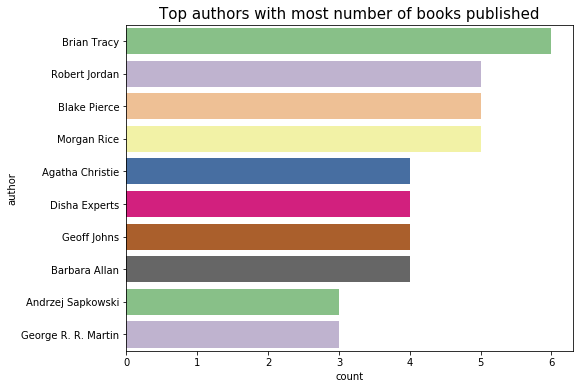

In [25]:
plt.figure(figsize=(8,6))
sns.countplot(y = "author", data = df2, order = authors.index, palette = "Accent")
plt.title('Top authors with most number of books published', fontsize = 15)
plt.show()

From the chart above one can see that Brian Tracy and Morgan Rice have the most books in the data.

**The most reviewed books**

The books with the largest number of voters:

In [26]:
books = df2.sort_values('voters', ascending = False).head(10).set_index('title')

C:\Users\PC\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


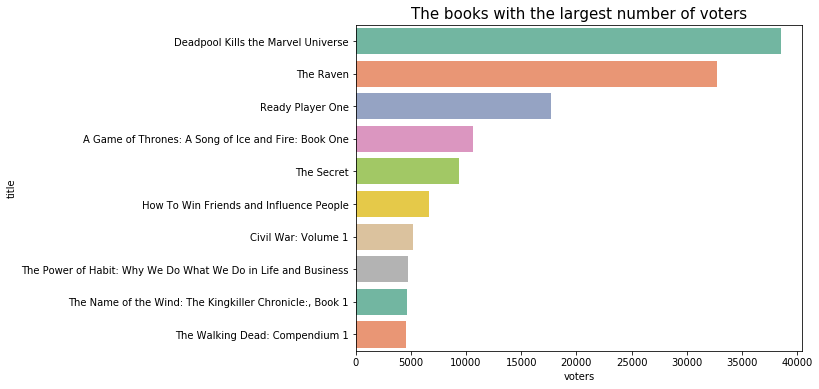

In [31]:
plt.figure(figsize=(8,6))
sns.barplot(books['voters'], books.index, palette='Set2')
plt.title('The books with the largest number of voters', fontsize = 15)
plt.show()

The voters column contains the number of voters for the book. Based on this column I receive the most commented books in the data. 

The "Deadpool Kills the Marvel Universe" has been rated more times than any other book and it reviewed almost 40000 times.  
The next  "The Raven" has received little less reviewed. 


**Top books by average rating**

The books with the best rating. For the analysis I choose book with voters above 500.

In [28]:
rating = df2[df2['voters']>500]

In [29]:
books_rated = rating[['rating','title']].groupby('title').mean().sort_values('rating', axis=0, ascending = False).head(10)
books_rated

,rating
title,
Morning Star,4.8
Death Masks,4.8
Thrawn (Star Wars),4.7
The Shadow Rising: Book Four of 'The Wheel of Time',4.7
The Eye of the World: Book One of 'The Wheel of Time',4.7
"Mistborn Trilogy: The Final Empire, The Well of Ascension, The Hero of Ages",4.7
A Game of Thrones: A Song of Ice and Fire: Book One,4.6
"The Lord of the Rings: The Fellowship of the Ring, The Two Towers, The Return of the King",4.6
The Fires of Heaven: Book Five of 'The Wheel of Time',4.6


C:\Users\PC\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


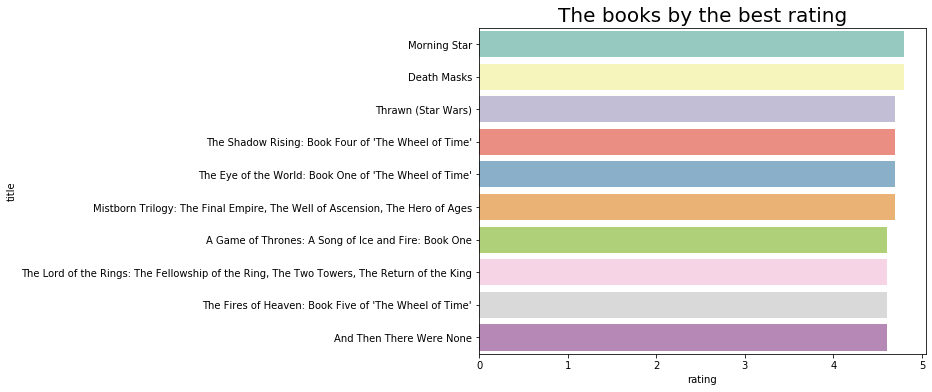

In [30]:
plt.figure(figsize=(8,6))
sns.barplot(books_rated['rating'], books_rated.index, palette='Set3')
plt.title('The books by the best rating', fontsize = 20)
plt.show()

From chart above one can see that the books with high rating are "Morning Star" and "Death Masks". They have rating 4.8.


**The publisher with most number of books published**

In [32]:
publisher = df2['publisher'].value_counts().head(10)
publisher

Hachette UK             20
Marvel Entertainment    15
Simon and Schuster      15
Penguin                 15
HarperCollins UK        14
DC                      13
Harper Collins           7
Del Rey                  6
AMACOM                   6
Blake Pierce             5
Name: publisher, dtype: int64

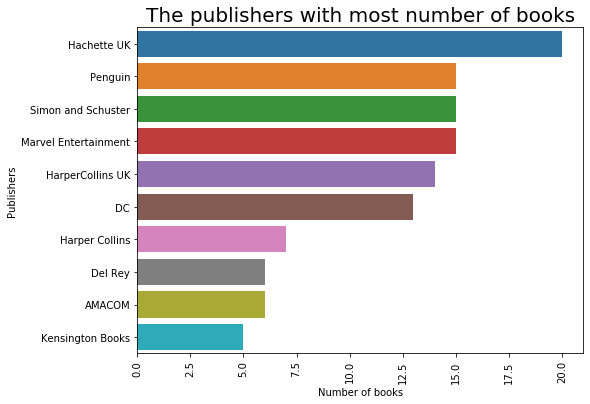

In [38]:
plt.figure(figsize=(8,6))
sns.barplot(x=publisher,y=publisher.index)
plt.xticks(rotation=90)
plt.ylabel('Publishers')
plt.xlabel('Number of books')
plt.title('The publishers with most number of books', fontsize = 20)
plt.show()

The publisher with the most number of books published is "Hachette UK" with 20 books and "Penguin" with 15 as well.


**Year of publishing**

The number of published books by years:

In [33]:
pub_year = df2.Year.value_counts().head(10)
pub_year

2019    45
2014    24
2011    20
2016    19
2015    19
2010    17
2012    15
2013    14
2009    11
2017    11
Freq: A-DEC, Name: Year, dtype: int64

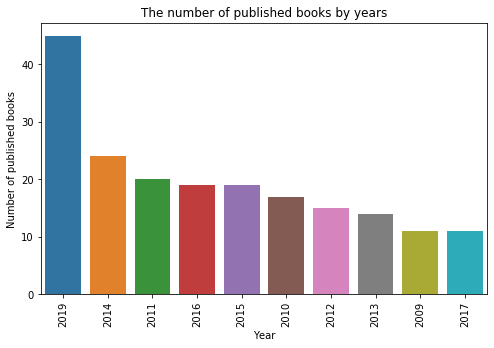

In [40]:
plt.figure(figsize=(8,5))
sns.barplot(x=pub_year.index,y=pub_year)
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of published books')
plt.title('The number of published books by years')
plt.show()

The year 2019 marks the highest number of published books.

**Distributions of variables**

Average rating distribution for the books:

C:\Users\PC\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


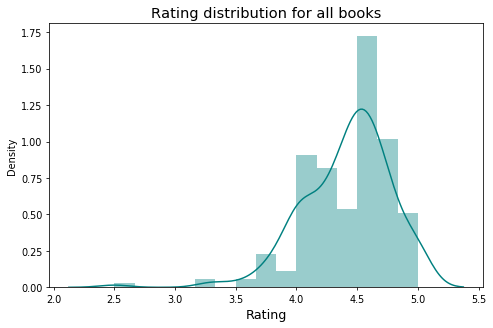

In [50]:
plt.figure(figsize=(8,5), dpi = 70)
sns.distplot(df2.rating, color = 'teal')
plt.xlabel('Rating', fontsize=13)
plt.title('Rating distribution for all books',fontsize=15)
plt.show();

**Voters count distribution**

C:\Users\PC\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


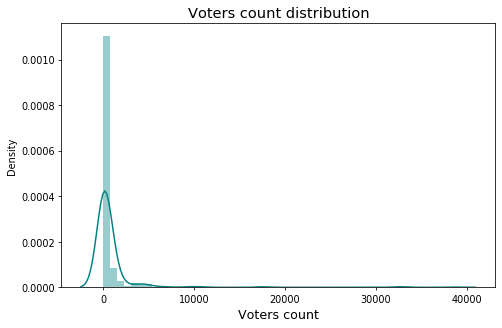

In [51]:
plt.figure(figsize=(8,5), dpi = 70)
sns.distplot(df.voters, color = 'teal')
plt.xlabel('Voters count', fontsize=13)
plt.title('Voters count distribution',fontsize=15)
plt.show();

#### Relationships between variables

Relationship between rating and voters

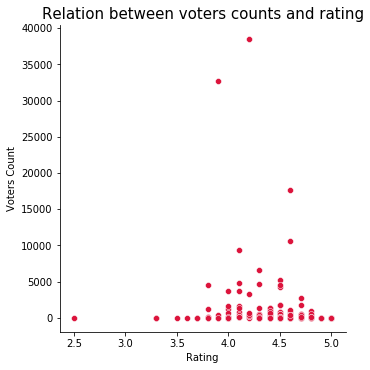

In [45]:
ax = sns.relplot(data=df2, x="rating", y="voters", color = 'crimson', sizes=(100, 200), height=5, marker='o')
plt.title("Relation between voters counts and rating",fontsize = 15)
ax.set_axis_labels("Rating", "Voters Count");

From above plots one can see that majority of the ratings lie approximately near 4.0-5.0.

## Recommendation system

### 1. The Simplest Recommendation System

Simple Recommendations are the basic systems that recommend the best items based on a specific metric or score. 
One of the most basic metrics to get direct recommendations is rating. We can just find the most popular books and it is probably that the most of users will like them. But just using average rating of the books is not a very good way because it cannot take popularity and number of votes into consideration. Therefore I use the weighted rating which takes into account the average rating and number of votes it has collected. This system will make sure that a book with a 5 rating from 1000 voters gets a higher score than a book with the same rating but a little few voters.

Mathematically the formula is represented as follows:

**Weighted Rating(WR) = vR/(v+m) + mC/(v+m)**

- v is the number of votes for the book
- m is the minimum votes required to be listed
- R is the average rating of the book
- C is the average rating of all books

In this method following steps are made: we decide on the metric or score to rate book on, then we calculate the score for every book and finally we sort the books based on the score and output the top results. 

First I calculate the value of C: the mean rating across all books. 

In [34]:
C = df2['rating'].mean()
print(C)

4.415094339622644


Next I calculate the number of votes m which received by a book in the 90th percentile by using quantile() method.

In [35]:
m = df2['voters'].quantile(0.90)
print(m)

1370.7999999999997


In [36]:
#filter out all qualified books into a new DataFrame
q_book = df2.copy().loc[df2['voters'] >= m]
q_book.shape

(23, 14)

Next step I define function to calculate the weighted rating for each qualified book and then I define a new value 'score' and calculate its value with function.

In [39]:
def weighted_rating(df, m=m, C=C):
    """Function for compute the weighted rating of each book"""
    v = df['voters']
    R = df['rating']
    weight = (v/(v+m) * R) + (m/(m+v) * C)
    return weight

In [40]:
q_book['score'] = q_book.apply(weighted_rating, axis=1)

Finally I sort the DataFrame in descending order by the score column and output the title, voters , rating  and score of the top 15 books.

In [41]:
q_book = q_book.sort_values('score', ascending=False)

In [42]:
#print the top 15 movies
q_book[['title', 'voters', 'rating', 'score']].head(10)

,title,voters,rating,score
285,"Mistborn Trilogy: The Final Empire, The Well o...",2700,4.7,4.604061
362,Ready Player One,17719,4.6,4.586722
69,A Game of Thrones: A Song of Ice and Fire: Boo...,10650,4.6,4.578914
1144,The Eye of the World: Book One of 'The Wheel o...,1780,4.7,4.576048
56,Civil War: Volume 1,5177,4.5,4.482225
882,The Walking Dead: Compendium 1,4533,4.5,4.480286
190,It,4260,4.5,4.479330
239,A Dance with Dragons: A Song of Ice and Fire: ...,1799,4.5,4.463282
654,Batman: Year One,1756,4.5,4.462777
32,How to Win Friends and Influence People,1382,4.4,4.407516


### 2. Content-Based Recommender

The content-based recommendations suggest similar items based on a particular item. This method uses item data such as a description, genre etc. to find its similarity with other items and  make the reccomendations. 

In our case will be recommended the books that are similar to each other. To build that system I will compute pairwise cosine similarity scores for all books based on their description and  recommend books based on that similarity score threshold. 

Because the data are in  Natural Language, I will have to calculate the word vectors for the data and find the similarity between each vector. I will use Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. The TF-IDF score gives us the frequency of words occuring in a document to helps us evaluating the similarity between two documents. 

First I create the TF-IDF Matrix and remove all english stop words such as 'the', 'a':

In [43]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df2['description'])

tfidf_matrix.shape

(225, 7273)

Now I use Cosine Similarity to find the similarity between two books:

In [44]:
# Computing the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(225, 225)

In [45]:
cosine_sim[0]

array([1.00000000e+00, 2.35631081e-03, 0.00000000e+00, 0.00000000e+00,
       4.96015043e-03, 6.19998151e-03, 1.26417590e-02, 3.69430570e-02,
       1.36257265e-02, 8.32862802e-03, 5.04780052e-03, 4.79631399e-02,
       1.63474078e-02, 1.95614873e-02, 1.03902866e-02, 9.01806959e-03,
       1.31800881e-02, 2.46933316e-02, 1.55155993e-02, 5.39302693e-02,
       4.29098458e-02, 1.81543417e-02, 9.50803351e-03, 3.21691150e-02,
       1.03336778e-02, 1.48651067e-02, 1.48399539e-02, 0.00000000e+00,
       1.36239207e-02, 2.50579726e-02, 1.40138012e-02, 1.01929319e-02,
       4.57287516e-02, 2.06531587e-02, 1.28714128e-02, 1.34734055e-02,
       6.71350587e-03, 1.82842619e-02, 1.22402083e-02, 1.61094407e-02,
       1.75455101e-03, 3.52962695e-02, 2.40723402e-02, 5.07849422e-03,
       1.83343256e-02, 2.78953818e-02, 2.54227124e-02, 6.65151319e-03,
       5.32535828e-02, 1.63999073e-02, 1.82814228e-02, 3.89576873e-02,
       6.34676092e-03, 9.13140877e-03, 2.88676296e-02, 3.27735831e-02,
      

Then I construct a reverse map of indices and book titles:

In [46]:
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()
indices[:5]

title
Antiques Roadkill: A Trash 'n' Treasures Mystery    1
The Art of Super Mario Odyssey                      2
The Painted Man (The Demon Cycle, Book 1)           4
God of War: The Official Novelization               6
Edgedancer: From the Stormlight Archive             7
dtype: int64

Finally I create recommendation function which takes the book title as input and the outputs are the similar books:

In [47]:
def get_recommendations(title, cosine_sim=cosine_sim):
    """Function to create recommendations"""
    index = indices[title]
    sim_score = list(enumerate(cosine_sim[index]))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
    sim_score = sim_score[1:11]
    book_indices = [i[0] for i in sim_score]
    return df2['title'].iloc[book_indices]

Predictions:

In [48]:
get_recommendations('The Raven')

378                                           Death Masks
770                                             The Joker
8       Blood, Sweat, and Pixels: The Triumphant, Turb...
149                                     Gangster: A Novel
58      The Guardians: The explosive new thriller from...
1089                         Batman: Arkham Knight Vol. 3
97                                  Now or Never: A Novel
670                                         The Black Box
154            Kings and Sorcerers Bundle (Books 2 and 3)
54                Little Girl Lost: A Lucy Black Thriller
Name: title, dtype: object

In [49]:
get_recommendations('How To Win Friends and Influence People')

62      Competitive Advantage: Creating and Sustaining...
383     Business Strategy (The Brian Tracy Success Lib...
147          Management (The Brian Tracy Success Library)
171     Platform Revolution: How Networked Markets Are...
215     Goals!: How to Get Everything You Want -- Fast...
378                                           Death Masks
992     Becoming Steve Jobs: The Evolution of a Reckle...
229     The Power of Habit: Why We Do What We Do in Li...
131                             Principles: Life and Work
1084      Leadership 101: What Every Leader Needs to Know
Name: title, dtype: object

**Genres Based Recommender**

In this section I will build a recommender system based on genres of books. This kind of recommender is based on books genres and anytime one user inputs book's title the system will provide him with 10 possible books that are similar to the his chooses. 

Next steps are the same at previous example. I will use 'genre' to make recommendations but for this model I will use the CountVectorizer() instead of TF-IDF one. This is because we do not want to down-weight any features that we are using for this analysis. The main difference between CountVectorizer() and TF-IDF is the inverse document frequency (IDF) component which is present in later and not in the former.

I define a Count Vectorizer Object and remove all english stop words:

In [50]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['generes'])

count_matrix.shape

(225, 153)

Next I will use the cosine similarity to measure the distance between the embeddings:

In [51]:
#computing the Cosine Similarity matrix based on the count matrix
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

The I reset index of main DataFrame and construct reverse mapping:

In [52]:
df3 = df2.reset_index()
indices = pd.Series(df3.index, index=df3['title'])

Predictions:

In [53]:
get_recommendations('The Raven', cosine_sim2)

283                                              Candide
79     The Weight of Honor (Kings and Sorcerers--Book 3)
675                           The Man in the High Castle
22     The Last Wife: An absolutely gripping and emot...
25          Prince of Thorns (The Broken Empire, Book 1)
29                                          Morning Star
35     The Empty Nest: An unputdownably gripping psyc...
36                                              Salvaged
78     No Mercy: The brand new novel from the Queen o...
84                      Final Option: 'The best one yet'
Name: title, dtype: object

In [54]:
get_recommendations('How To Win Friends and Influence People', cosine_sim2)

1084      Leadership 101: What Every Leader Needs to Know
207     Freakonomics Rev Ed: A Rogue Economist Explore...
736     Predictably Irrational: The Hidden Forces that...
26                Influence: The Psychology of Persuasion
32                How to Win Friends and Influence People
67      Secrets of the Millionaire Mind: Mastering the...
76      Good to Great: Why Some Companies Make the Lea...
131                             Principles: Life and Work
147          Management (The Brian Tracy Success Library)
202     The Neatest Little Guide to Stock Market Inves...
Name: title, dtype: object

In [55]:
get_recommendations('The Secret', cosine_sim2)

215     Goals!: How to Get Everything You Want -- Fast...
261                                            The Secret
678     One Small Step Can Change Your Life: The Kaize...
1091                The Law of Success in Sixteen Lessons
61                                   The Art Of Seduction
71      Happy: Why More or Less Everything is Absolute...
517                                10 Ways to be annoying
73          The Ultimate Secrets of Total Self-Confidence
376     You Are a Badass: How to Stop Doubting Your Gr...
280     Getting Things Done: The Art of Stress-Free Pr...
Name: title, dtype: object

### Summary

This project was aimed to build book recommendation system with two methods: the simplest recommendation system and Content-Based filtering. I have started with data analysis to better meet the data. Then I have cleaned data and prepared them to the modelling. Following I have used two methods to get python functions that user can input one book's name then the system can provide the other most possible books that he can to read. Finally I have received some reccomendation for choosen books and as one can see the models show a pretty decent results. 